In [1]:
"""
FH2  cutout + catalogue + PSF loader
Python 3.8  ‖  2025-07-18
"""
from pathlib import Path
from typing import Dict, Union
from repsf import resample_psf_to_common
import matplotlib.pyplot as plt
from astropy.io import fits
import json
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import  util


from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction as Reconstruction

import numpy as np
import galsim
import pandas as pd
from astropy.io import fits      # ⭐ 需要 astropy；NOIRLab Notebook 有预装
from pathlib import Path
from typing import Union, Dict
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import lensviz_new_3 as lv
import multiprocessing


# ========= 0. 基础配置 =========
ROOT          = Path("/home/zizhao/jasmine-worksapce/FH2/")
CATALOG_CSV   = ROOT / "fh2_desils_exploded_withID.csv"
RESID_DIR      =ROOT / "resid"
IMG_DIR       = ROOT / "fitscutout"
PSF_DIR       = ROOT / "psfcoadd"          # 与 cutout 同一像素标尺
ROUND_DIGITS  = 5                          # 文件名保留位数
DEFAULT_PIXSCALE = 0.262                  # ″/pix，Legacy LS-DR9 cutout 默认值

# ========= 1. 帮助函数 =========
def build_cutout_name(ra: float, dec: float) -> str:
    """拼接 cutout 文件名。"""
    return f"ra_{ra:.{ROUND_DIGITS}f}_dec_{dec:.{ROUND_DIGITS}f}-subimage.fits"

def build_cutout_name_resid(ra: float, dec: float) -> str:
    """拼接 cutout 文件名。"""
    return f"ra_{ra:.{ROUND_DIGITS}f}_dec_{dec:.{ROUND_DIGITS}f}-resid.fits"

def build_psf_name(ra: float, dec: float) -> str:
    """
    ★ 若 PSF cutout 文件与你的图像命名方式一致，可直接共用。
    否则在此改写成实际模式。
    """
    return f"ra_{ra:.{ROUND_DIGITS}f}_dec_{dec:.{ROUND_DIGITS}f}.fits"

def load_grz_layers(fits_path: Path) -> Dict[str, np.ndarray]:
    """
    读取 g/r/z 及各自 ivar。
    若 ivar 缺失则返回 None，便于后续判定。
    """
    with fits.open(fits_path) as hdul:
        data_ext = [h.data.astype(float) for h in hdul[1:]]   # 忽略 primary
    nlayer = len(data_ext)
    order6 = ["g", "g_ivar", "r", "r_ivar", "z", "z_ivar"]
    order8 = ["g", "g_ivar", "r", "r_ivar", "i", "i_ivar", "z", "z_ivar"]
    mapping = order6 if nlayer == 6 else order8 if nlayer == 8 else None
    if mapping is None:
        raise RuntimeError(f"{fits_path} 层数={nlayer} 不在 6/8 之中")

    layer_dict = {k: arr for k, arr in zip(mapping, data_ext) if k[0] in "grz"}
    # 确保 grz 键都在
    for band in "grz":
        layer_dict.setdefault(band,      None)
        layer_dict.setdefault(f"{band}_ivar", None)
    return layer_dict

def fallback_world2pix(ra_deg, dec_deg, img_shape, ra_c, dec_c, pixscale_arcsec=DEFAULT_PIXSCALE):
    """
    无 WCS fallback：小视场近似 TAN；x方向考虑 cos(dec)。
    返回 0-based pixel 坐标；origin='lower'。
    """
    ny, nx = img_shape
    deg_per_pix_y = pixscale_arcsec / 3600.0
    deg_per_pix_x = deg_per_pix_y / np.cos(np.deg2rad(dec_c))
    x0 = (nx - 1) / 2.0
    y0 = (ny - 1) / 2.0
    ra_arr  = np.asarray(ra_deg)
    dec_arr = np.asarray(dec_deg)
    x = x0 + (ra_arr - ra_c) / deg_per_pix_x
    y = y0 + (dec_arr - dec_c) / deg_per_pix_y
    return x, y

def RaDec2XY(ra_arr, dec_arr, ra_c, dec_c):
    pixel_decals=0.262
    image_size = 21
    image      = galsim.Image(image_size, image_size)
    cen_coord  = galsim.CelestialCoord(ra_c * galsim.degrees, dec_c * galsim.degrees)
    affine_wcs = galsim.PixelScale(pixel_decals).affine().shiftOrigin(image.center)
    wcs        = galsim.TanWCS(affine_wcs, world_origin=cen_coord)
    image.wcs  = wcs
    x_mbr_arr  = np.array([])
    y_mbr_arr  = np.array([])

    for ra, dec in zip(ra_arr, dec_arr):
        coord      = galsim.CelestialCoord(ra*galsim.degrees, dec*galsim.degrees)
        image_pos  = wcs.toImage(coord)
        x_mbr_arr  = np.append(x_mbr_arr, image_pos.x)
        y_mbr_arr  = np.append(y_mbr_arr, image_pos.y)
        
    return (x_mbr_arr, y_mbr_arr)

def take_first_two_rows(df: pd.DataFrame) -> pd.DataFrame:
    """ID=1-3 取前两行，其余保持原样。"""
    return df.sort_values("ID").head(2)

def crop_center_21(arr: np.ndarray) -> np.ndarray:
    """
    将任意尺寸的矩阵/图像裁剪为中心 21×21 区域。

    Parameters
    ----------
    arr : np.ndarray
        输入数组，至少 2 维。前两维表示 (H, W)。

    Returns
    -------
    np.ndarray
        裁剪后的数组，尺寸为 (21, 21, …)。
    """
    if arr.ndim < 2:
        raise ValueError("输入至少应为 2 维矩阵")

    H, W = arr.shape[-2], arr.shape[-1]
    if H < 21 or W < 21:
        raise ValueError(f"输入尺寸 ({H}, {W}) 过小，无法裁剪 21×21")

    half = 10                       # 21 的半径
    cy, cx = H // 2, W // 2         # 中心坐标（向下取整）
    y1, y2 = cy - half, cy + half + 1  # [cy-10, cy+10] 共 21 个像素
    x1, x2 = cx - half, cx + half + 1

    # 先针对最后两维裁剪，其余维度保持不变
    return arr[..., y1:y2, x1:x2] if arr.ndim > 2 else arr[y1:y2, x1:x2]



def locate_global_significant_from_resid(
    ra_c: float,
    dec_c: float,
    resid_dir: Union[str, Path] = None,
    layer_index: int = 3,  # 0-based: 第4层
) -> Dict[str, Union[str, int, float]]:
    if resid_dir is None:
        global resid_path
        resid_dir = resid_path

    resid_dir = Path(resid_dir)
    fpath = resid_dir / build_cutout_name_resid(ra_c, dec_c)
    print(fpath)
    if not fpath.exists():
        raise FileNotFoundError(f"File not found: {fpath}")

    with fits.open(fpath) as hdul:
        cube = np.asarray(hdul[0].data, dtype=float)   # (nz, ny, nx)
        data = cube[layer_index, :, :]                  # 第4层
        # 只保留天球轴，避免3D WCS导致的参数数量不匹配
        w = WCS(hdul[0].header).celestial

    if not np.isfinite(data).any():
        raise ValueError("所选图层数据全部为 NaN，无法寻找显著像素。")

    idx = np.nanargmax(np.abs(data))
    y_pix, x_pix = np.unravel_index(idx, data.shape)
    
    resid_value = float(data[y_pix, x_pix])
    # 注意：使用 w.celestial 后，这里传 x, y + origin 即可
    ra_peak, dec_peak = w.all_pix2world(float(x_pix), float(y_pix), 0)

    x_rel, y_rel = RaDec2XY([ra_peak], [dec_peak], ra_c, dec_c)

    return {

        "x_pix": int(x_pix),
        "y_pix": int(y_pix),
        "resid_value": resid_value,
        "ra_peak": float(ra_peak),
        "dec_peak": float(dec_peak),
        "x_rel": float(x_rel),
        "y_rel": float(y_rel),
    }

/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
cat = pd.read_csv(CATALOG_CSV)
grouped = cat.groupby(["ra", "dec"], sort=False)
for (ra_c, dec_c), grp in grouped:
    

        sub = take_first_two_rows(grp)
        cutout_path = IMG_DIR / build_cutout_name(ra_c, dec_c)
        psf_path    = PSF_DIR / build_psf_name(ra_c, dec_c)  # ← 若命名不同请改

        # ---------- 读 cutout ----------
        try:
            layers = load_grz_layers(cutout_path)
        except Exception as e:
            print(f"[WARN] 跳过 {cutout_path.name}: {e}")
            continue
        
        shape = layers["g"].shape if layers["g"] is not None else next(x.shape for x in layers.values() if x is not None)
        
        print(sub["ra_out"])
        print(sub["dec_out"])
        # ---------- 坐标转换 ----------
        # x_pix, y_pix = fallback_world2pix(
        #     sub["ra_out"].values, sub["dec_out"].values,
        #     img_shape=shape, ra_c=ra_c, dec_c=dec_c
        # )
        x_pix, y_pix = RaDec2XY(sub["ra_out"].values, sub["dec_out"].values, ra_c ,dec_c)
        
        # ---------- 读 PSF ----------

        if psf_path.exists():
            with fits.open(psf_path) as hdul:
                
                if len(hdul)==3:
                    psf_g = hdul[0].data.astype(float)
                    psf_r = hdul[1].data.astype(float)
                    psf_z = hdul[2].data.astype(float)
                    
                elif len(hdul)==4:
                    
                    psf_g = hdul[0].data.astype(float)
                    psf_r = hdul[1].data.astype(float)
                    psf_z = hdul[3].data.astype(float)
                else:
                    assert False, "PSF file wrong"
                    
                psf_g = resample_psf_to_common(psf_g, pixscale_in=0.454, pixscale_out=0.262, target_size=63)
                psf_r = resample_psf_to_common(psf_r, pixscale_in=0.454, pixscale_out=0.262, target_size=63)  
                psf_g=crop_center_21(psf_g)
                psf_r=crop_center_21(psf_r)
                psf_z=crop_center_21(psf_z)
                    
        # ---------- 准备输入 ----------
        data_g=layers["g"]
        data_r=layers["r"]
        data_z=layers["z"]
        ivar_g=layers["g_ivar"]
        ivar_r=layers["r_ivar"]
        ivar_z=layers["z_ivar"]
        psf_g=np.abs(psf_g);psf_g=(psf_g/psf_g.sum())
        psf_r=np.abs(psf_r);psf_r=(psf_r/psf_r.sum())
        psf_z=np.abs(psf_z);psf_z=(psf_z/psf_z.sum())
        
        
        rms_map_g = np.zeros_like(ivar_g);positive = ivar_g > 0;rms_map_g[positive] = 1 / np.sqrt(ivar_g[positive])
        rms_map_r = np.zeros_like(ivar_r);positive = ivar_r > 0;rms_map_r[positive] = 1 / np.sqrt(ivar_r[positive])
        rms_map_z = np.zeros_like(ivar_z);positive = ivar_z > 0;rms_map_z[positive] = 1 / np.sqrt(ivar_z[positive])
        
        if ra_c == 270.014699:
            print("STOP")
            break
        
        #-----------Lenstronomy--------
        # Lenstronomy_model(data_g,data_r,data_z,rms_map_g,rms_map_r,rms_map_z)

0    179.093347
1    179.093882
Name: ra_out, dtype: float64
0    21.987776
1    21.987996
Name: dec_out, dtype: float64
3    244.705929
4    244.706237
Name: ra_out, dtype: float64
3    6.476708
4    6.476812
Name: dec_out, dtype: float64
5    100.652815
6    100.653166
Name: ra_out, dtype: float64
5    56.28647
6    56.28632
Name: dec_out, dtype: float64
[WARN] 跳过 ra_4.94658_dec_1.50098-subimage.fits: /home/zizhao/jasmine-worksapce/FH2/fitscutout/ra_4.94658_dec_1.50098-subimage.fits 层数=16 不在 6/8 之中
10    65.581240
11    65.580991
Name: ra_out, dtype: float64
10   -4.797413
11   -4.797341
Name: dec_out, dtype: float64
13    9.315902
14    9.316204
Name: ra_out, dtype: float64
13    20.973792
14    20.973772
Name: dec_out, dtype: float64
[WARN] 跳过 ra_234.25436_dec_32.39078-subimage.fits: /home/zizhao/jasmine-worksapce/FH2/fitscutout/ra_234.25436_dec_32.39078-subimage.fits 层数=12 不在 6/8 之中
17    246.258188
18    246.258290
Name: ra_out, dtype: float64
17    43.15886
18    43.15872
Name: 

In [3]:
sep=2.25 #arcsec

In [5]:
# from pixmasker import MaskEditor
# %matplotlib widget
# editor = MaskEditor(
#     data_z,
#     stretch="asinh",       # 可选: 'linear' 或 'asinh'
#     percent_lo=1, percent_hi=99,  # 自动计算显示范围
#     # cmap="gray",         # 如需灰度可手动设置；默认用 matplotlib 的默认 colormap
#     brush_radius=5,        # 画笔半径（像素）
#     default_save_path="mask.npy"  # 按 s 快捷键默认保存位置
# )

# editor.show()

In [6]:
# editor.close()

In [4]:
mask = np.load("mask.npy").astype(bool)   # True=屏蔽
assert mask.shape == data_z.shape, f"mask shape {mask.shape} != image {data_z.shape}"

In [5]:
rms_map_g[mask]= 1e9
rms_map_r[mask]= 1e9
rms_map_z[mask]= 1e9

In [9]:
# def Lenstronomy_model(data_g,data_r,data_z,rms_map_g,rms_map_r,rms_map_z):
cutout_g=data_g[0:4,0:4]
rms_g=np.std(cutout_g)
cutout_r=data_r[0:4,0:4]
rms_r=np.std(cutout_r)
cutout_z=data_z[0:4,0:4]
rms_z=np.std(cutout_z)
    
deltaPix_g=0.262
numPix_g=data_g.shape[0]
psf_type_g='PIXEL'

_, _, ra_at_xy_0_g, dec_at_xy_0_g, _, _, Mpix2coord_g, _ = util.make_grid_with_coordtransform(numPix=numPix_g, deltapix=deltaPix_g, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_g = {'noise_map': rms_map_g,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_g,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_g,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_g,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_g,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_g={'psf_type': psf_type_g, 'kernel_point_source': psf_g, 'pixel_size': deltaPix_g}


kwargs_numerics_g = {'supersampling_factor': 4, 'supersampling_convolution': False}


#r_data_set
deltaPix_r=0.262
numPix_r=data_r.shape[0]
psf_type_r='PIXEL'

_, _, ra_at_xy_0_r, dec_at_xy_0_r, _, _, Mpix2coord_r, _ = util.make_grid_with_coordtransform(numPix=numPix_r, deltapix=deltaPix_r, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_r = {'noise_map': rms_map_r,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_r,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_r,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_r,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_r,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_r={'psf_type': psf_type_r, 'kernel_point_source': psf_r, 'pixel_size': deltaPix_r}


kwargs_numerics_r = {'supersampling_factor': 4, 'supersampling_convolution': False}

#z_data_set
deltaPix_z=0.262
numPix_z=data_z.shape[0]
psf_type_z='PIXEL'

_, _, ra_at_xy_0_z, dec_at_xy_0_z, _, _, Mpix2coord_z, _ = util.make_grid_with_coordtransform(numPix=numPix_z, deltapix=deltaPix_z, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_z = {'noise_map': rms_map_z,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_z,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_z,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_z,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_z,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }

kwargs_psf_z={'psf_type': psf_type_z, 'kernel_point_source': psf_z, 'pixel_size': deltaPix_z}

kwargs_numerics_z = {'supersampling_factor': 4, 'supersampling_convolution': False}

#multi_band_data
multi_band_list = [[kwargs_data_g, kwargs_psf_g, kwargs_numerics_g],[kwargs_data_r, kwargs_psf_r, kwargs_numerics_r],[kwargs_data_z, kwargs_psf_z, kwargs_numerics_z]]

#multi_band_joint
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear' }

#kwargs_model
lens_light_model_list = ['SERSIC_ELLIPSE']*3
point_source_list = ['UNLENSED'] 

#index_model_list
index_lens_light_model_list = [[0],[1],[2]]
index_point_source_model_list = [[0], [0], [0]] 

kwargs_model = dict(
    lens_light_model_list = lens_light_model_list,
    point_source_model_list = point_source_list,
    index_lens_light_model_list = index_lens_light_model_list,
    index_point_source_model_list = index_point_source_model_list,
)

#kwargs_likelihood
kwargs_likelihood = {'check_bounds': True, 'source_marg': False,'bands_compute': [True,True,True], 'check_positive_flux':True}

#kwargs_lens_light_params
kwargs_fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

x1=(x_pix[0]-10)*0.262
x2=(x_pix[1]-10)*0.262
y1=(y_pix[0]-10)*0.262
y2=(y_pix[1]-10)*0.262

# xcen=(x1+x2)/2
# ycen=(y1+y2)/2

res = locate_global_significant_from_resid(ra_c, dec_c, resid_dir=RESID_DIR)
xcen,ycen=(res["x_rel"],res["y_rel"])
xcen=(xcen-10)*0.262
ycen=(ycen-10)*0.262

#add g lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-sep/8, 'center_y':ycen-sep/8})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x':  xcen+sep/8, 'center_y': ycen+sep/8})

#add r lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-sep/8, 'center_y':ycen-sep/8})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x':  xcen+sep/8, 'center_y': ycen+sep/8})

#add z lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 0.7*0.262, 'e1': 0.01, 'e2': 0.01, 'center_x': xcen, 'center_y': ycen})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': xcen-sep/8, 'center_y':ycen-sep/8})
kwargs_upper_lens_light.append({'R_sersic': 2*0.262,'e1': 0.5, 'e2': 0.5, 'center_x':  xcen+sep/8, 'center_y': ycen+sep/8})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

#add point
kwargs_fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []


kwargs_ps_init  = [{'ra_image':[x1,x2], 'dec_image':[y1,y2]}]  # 2 个像
kwargs_ps_sigma = [{'ra_image':[0.02]*2, 'dec_image':[0.02]*2}]
kwargs_fixed_ps = [{}]          # 不固定振幅；线性求解器会加 point_amp
kwargs_lower_ps = [{'ra_image':[x1-0.262,x2-0.262], 'dec_image':[y1-0.262,y2-0.262]}]
kwargs_upper_ps = [{'ra_image':[x1+0.262,x2+0.262], 'dec_image':[y1+0.262,y2+0.262]}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {
            'lens_light_model': lens_light_params,
            'point_source_model': ps_params}

kwargs_constraints = {
                'joint_lens_light_with_lens_light':[[0, 1, ['center_x', 'center_y','e1', 'e2']],[0,2,['center_x', 'center_y','e1', 'e2']]],
                'num_point_source_list': [2]}





/home/zizhao/jasmine-worksapce/FH2/resid/ra_270.01470_dec_53.08359-resid.fits


In [10]:
print(xcen,ycen)
print(x1,y1)
print(x2,y2)

-0.26199999985520955 7.237195021048137e-11
0.6956773437799507 0.9335208684486941
-0.6244362533526429 -0.8883730126090621


In [11]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

threadcount=100
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100, 'threadCount': threadcount}], 
                       ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1,'threadCount': threadcount}]]

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 300, 'threadCount': threadcount}], 
#                        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-2.1694316398994484 reduced X^2 of best position
-1413.3847133944905 log likelihood
1303.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.19037341501993113, 'n_sersic': 4, 'e1': 0.49843351231967303, 'e2': -0.10442234962664133, 'center_x': -0.3923167229462914, 'center_y': -0.1953114270483409}, {'amp': 1, 'R_sersic': 0.1946450430163561, 'n_sersic': 4, 'e1': 0.49843351231967303, 'e2': -0.10442234962664133, 'center_x': -0.3923167229462914, 'center_y': -0.1953114270483409}, {'amp': 1, 'R_sersic': 0.15645938128788436, 'n_sersic': 4, 'e1': 0.49843351231967303, 'e2': -0.10442234962664133, 'center_x': -0.3923167229462914, 'center_y': -0.1953114270483409}] lens light result
[{'ra_image': array([ 0.47744644, -0.82527299]), 'dec_image': array([ 0.71735498, -1.09482221]), 'point_amp': array([1., 1.])}] point source result
{} special param result
134.2325267791748 time use

100%|██████████| 100/100 [02:15<00:00,  1.35s/it]

Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  50
Sampling iterations (in current run): 100
136.58993673324585 time taken for MCMC sampling


In [12]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="viridis")
print(kwargs_result)

-2.1353898239910576 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.701470774139916
reduced chi^2 of data  1 =  3.997395844463669
reduced chi^2 of data  2 =  0.7073028533695886
{'kwargs_lens': [], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 0.008362229277622034, 'R_sersic': 0.2078531437354726, 'n_sersic': 4, 'e1': 0.4830712807052971, 'e2': -0.1726428873906704, 'center_x': -0.3735872158472657, 'center_y': -0.2543820724252405}, {'amp': 0.3985711930458185, 'R_sersic': 0.23744876496445724, 'n_sersic': 4, 'e1': 0.4830712807052971, 'e2': -0.1726428873906704, 'center_x': -0.3735872158472657, 'center_y': -0.2543820724252405}, {'amp': 3.9442578549794898, 'R_sersic': 0.17872487199807952, 'n_sersic': 4, 'e1': 0.4830712807052971, 'e2': -0.1726428873906704, 'center_x': -0.3735872158472657, 'center_y': -0.2543820724252405}], 'kwargs_ps': [{'ra_image': array([ 0.47335388, -0.82817013]), 'dec_image': array([ 0.71680126, -

In [6]:
#save chain
root_dir=Path("/home/zizhao/jasmine-worksapce/FH2/result-single-model/")
save_dir=Path(root_dir/f"ra_{ra_c:.5f}_dec_{dec_c:.5f}",)
save_dir.mkdir(parents=True, exist_ok=True)




In [ ]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
np.savetxt(save_dir/"samples_mcmc.txt",samples_mcmc)
np.savetxt(save_dir/"dist_mcmc.txt",dist_mcmc)

with open(save_dir/"param_mcmc.txt",'w') as f:
    json.dump(param_mcmc,f)


In [14]:
# save g fits                  
numPix_s=21
deltaPix_s=0.262

model_data_g=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=0)

model_g=model_data_g[0]
source_g= model_data_g[1]
lens_g= model_data_g[2]
image_g= model_data_g[3]
norm_res_g=model_data_g[4]

fname_f=save_dir/'g_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_g,name='data')
model_f=fits.ImageHDU(model_g,name='model')
lens_f=fits.ImageHDU(lens_g,name='lens')
image_f=fits.ImageHDU(image_g,name='image')
source_f=fits.ImageHDU(source_g,name='source')
norm_res_f=fits.ImageHDU(norm_res_g,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save r fits
model_data_r=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=1)

model_r=model_data_r[0]
source_r= model_data_r[1]
lens_r= model_data_r[2]
image_r= model_data_r[3]
norm_res_r=model_data_r[4]


fname_f=save_dir/'r_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_r,name='data')
model_f=fits.ImageHDU(model_r,name='model')
lens_f=fits.ImageHDU(lens_r,name='lens')
image_f=fits.ImageHDU(image_r,name='image')
source_f=fits.ImageHDU(source_r,name='source')
norm_res_f=fits.ImageHDU(norm_res_r,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save z fits
model_data_z=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=2)

model_z=model_data_z[0]
source_z= model_data_z[1]
lens_z= model_data_z[2]
image_z= model_data_z[3]
norm_res_z=model_data_z[4]

fname_f=save_dir/'z_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_z,name='data')
model_f=fits.ImageHDU(model_z,name='model')
lens_f=fits.ImageHDU(lens_z,name='lens')
image_f=fits.ImageHDU(image_z,name='image')
source_f=fits.ImageHDU(source_z,name='source')
norm_res_f=fits.ImageHDU(norm_res_z,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)



#转化结果中的array以确保能够保存json文件
def numpy_to_dict(d):  
    """Recursively convert numpy arrays to lists in a dict."""  
    if isinstance(d, np.ndarray):  
        return d.tolist()  
    elif isinstance(d, dict):  
        return {k: numpy_to_dict(v) for k, v in d.items()}  
    elif isinstance(d, list):  
        return [numpy_to_dict(v) for v in d]  
    else:  
        return d 

# 转换 NumPy 数组  
kwargs_result = numpy_to_dict(kwargs_result) 
with open(save_dir/'kwargs_result.json','w') as f:
    json.dump(kwargs_result,f)
    


[lensviz] saved: result-single-model/ra_270.01470_dec_53.08359/g_6panels_bwr.png


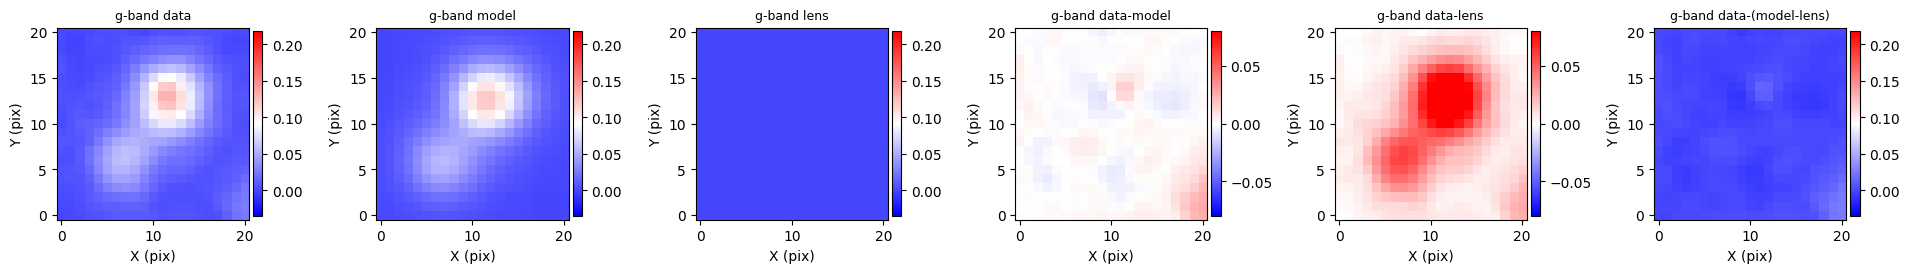

[lensviz] saved: result-single-model/ra_270.01470_dec_53.08359/r_6panels_bwr.png


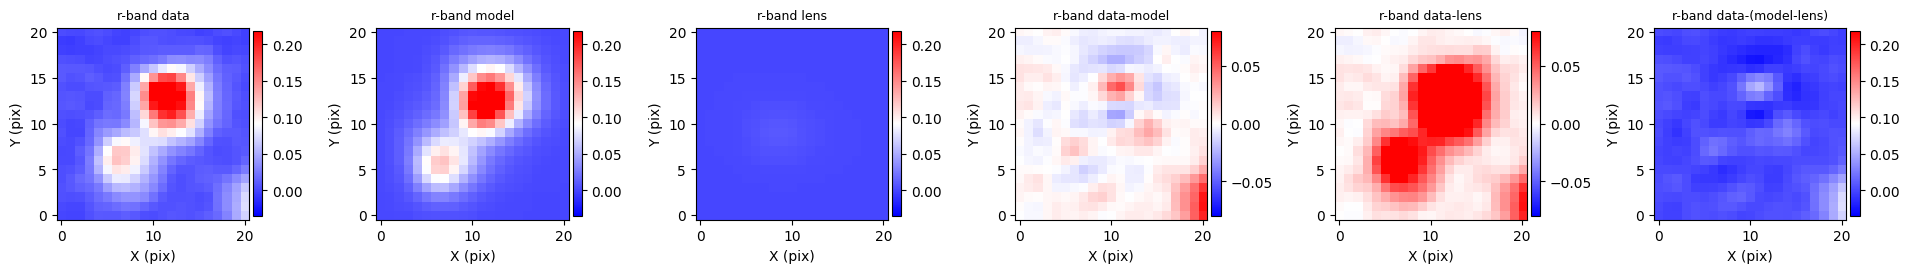

[lensviz] saved: result-single-model/ra_270.01470_dec_53.08359/z_6panels_bwr.png


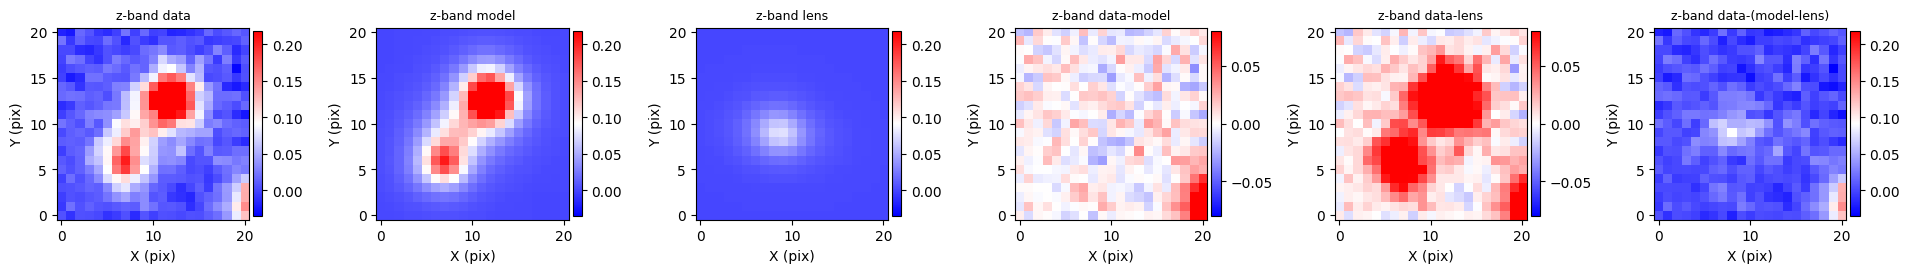

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_270.01470_dec_53.08359


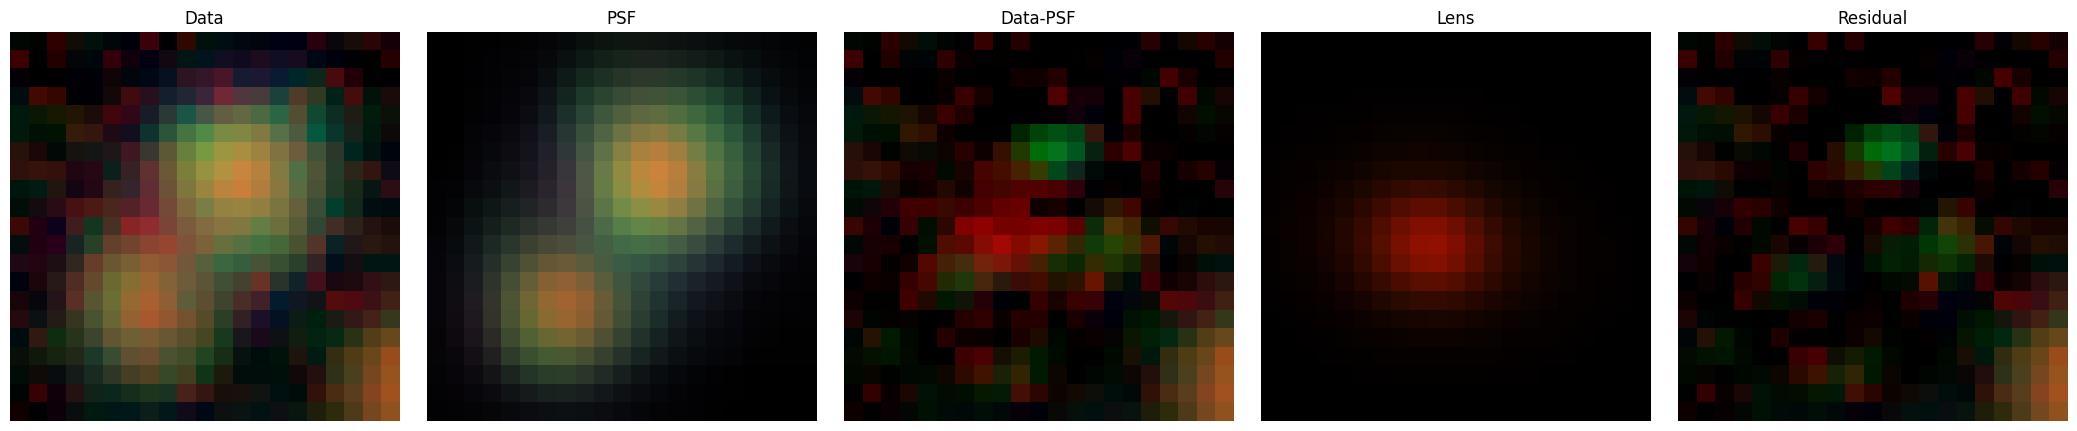

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_270.01470_dec_53.08359


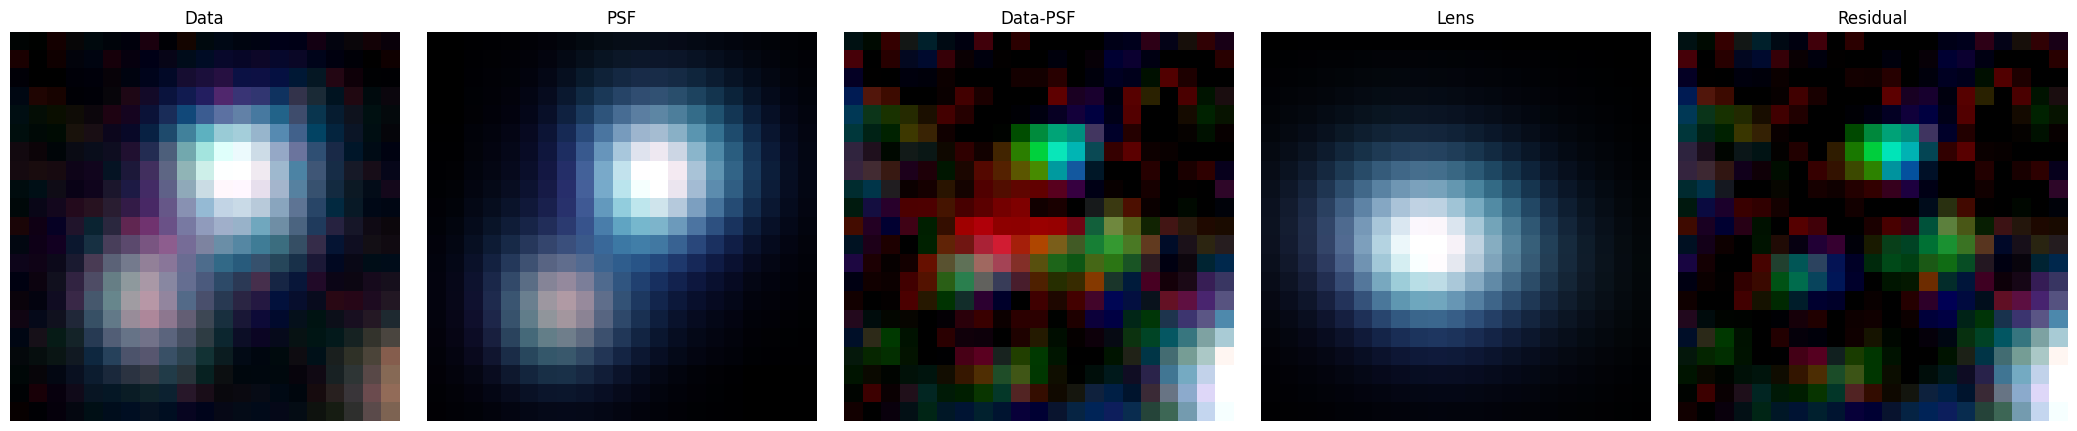

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_270.01470_dec_53.08359


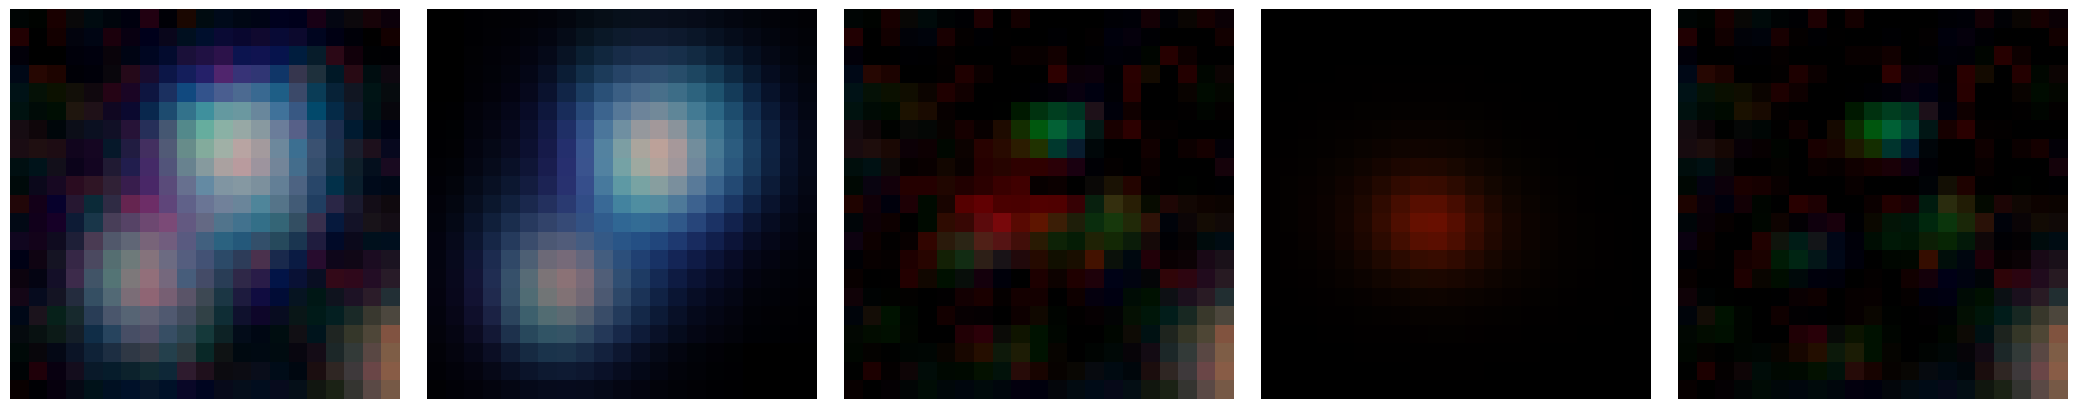

In [7]:
plt.close('all')
# ---------- 结果可视化 ----------
# 1. 创建可视化器（自动搜寻 results/ra_xx_dec_xx 目录）
viz = lv.LensViz(
    ra=ra_c, dec=dec_c,
    results_root=Path("result-single-model"),   # 根目录
    bands=("g", "r", "z"),          # 需要处理的波段
    
    stretch_kind="linear",          # or 'asinh'
)

# 2. 读取 FITS 并构建内部 band_data 字典
viz.load()

# 3. 单波段六面板图（自动保存到 results_dir）
viz.plot_all()         # 依次画 g/r/z

# 4. 一键生成 RGB 画廊
viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="lupton",            # 或 'asinh'
    save_prefix="grz_rgb"       # 会批量写入 PNG
)

viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="asinh",            # 或 'asinh'
    save_prefix="grz_rgb"       # 会批量写入 PNG
)

viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="humvi",
    Q=1.5, alpha=10, scales=(0.6, 0.8, 1.7),
    save_prefix="grz_rgb_humvi",
    show_titles=False,         # 显示列标题
    title_fontsize=25         # 可选，默认已是 12
)

In [8]:
# begin chain process
def flux_to_mag(flux):
    mag = -2.5*np.log10(flux)+22.5
    return mag

In [9]:
import lenstronomy.LensModel.Profiles.sersic_utils as sersic_utils
from lenstronomy.Util.param_util import ellipticity2phi_q

In [10]:
samples_mcmc=np.loadtxt(save_dir/"samples_mcmc.txt")
dist_mcmc=np.loadtxt(save_dir/"dist_mcmc.txt")
with open(save_dir/'kwargs_result.json') as f:
    kwargs_result_new=json.load(f)
with open(save_dir/'param_mcmc.txt') as f:
    param_mcmc=json.load(f)

In [11]:
SersicUtil=sersic_utils.SersicUtil()
def param_chain_reconstruction(i):
    #重构
    kwargs_result_new['kwargs_lens_light'][0]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][0]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    kwargs_result_new['kwargs_lens_light'][1]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light1')]
    kwargs_result_new['kwargs_lens_light'][1]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][1]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    kwargs_result_new['kwargs_lens_light'][2]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light2')]
    kwargs_result_new['kwargs_lens_light'][2]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][2]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    d=kwargs_result_new['kwargs_ps'][0]

    d['ra_image'][0],d['ra_image'][1]=samples_mcmc[i,param_mcmc.index("ra_image")],samples_mcmc[i,(param_mcmc.index("ra_image")+1)]
    d['dec_image'][0],d['dec_image'][1]=samples_mcmc[i,param_mcmc.index("dec_image")],samples_mcmc[i,(param_mcmc.index("dec_image")+1)]

    phi_lens,q_lens=ellipticity2phi_q(samples_mcmc[i,param_mcmc.index('e1_lens_light0')],samples_mcmc[i,param_mcmc.index('e2_lens_light0')])
    phi_lens=np.rad2deg(phi_lens)

    lens_light_reconstruction=Reconstruction(multi_band_list,kwargs_model,kwargs_result_new,multi_band_type='multi-linear',kwargs_likelihood=kwargs_likelihood,verbose=False)

    lens_light_image_model_g=lens_light_reconstruction.band_setup(band_index=0)
    lens_light_image_model_r=lens_light_reconstruction.band_setup(band_index=1)
    lens_light_image_model_z=lens_light_reconstruction.band_setup(band_index=2)

    kwargs_reconstructed_g=lens_light_image_model_g[1]
    kwargs_reconstructed_r=lens_light_image_model_r[1]
    kwargs_reconstructed_z=lens_light_image_model_z[1]

    #重构完毕，读取amp
    sersic_amp_g=kwargs_reconstructed_g['kwargs_lens_light'][0]['amp']
    sersic_amp_r=kwargs_reconstructed_r['kwargs_lens_light'][0]['amp']
    sersic_amp_z=kwargs_reconstructed_z['kwargs_lens_light'][0]['amp']

    ps1_amp_g,ps2_amp_g=kwargs_reconstructed_g['kwargs_ps'][0]["point_amp"]
    ps1_amp_r,ps2_amp_r=kwargs_reconstructed_r['kwargs_ps'][0]["point_amp"]
    ps1_amp_z,ps2_amp_z=kwargs_reconstructed_z['kwargs_ps'][0]["point_amp"]

    #amp 转为星等

    flux_lens_g= SersicUtil.total_flux(sersic_amp_g, kwargs_result_new['kwargs_lens_light'][0]['R_sersic'], kwargs_result_new['kwargs_lens_light'][0]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][0]['e1'], kwargs_result_new['kwargs_lens_light'][0]['e2'])

    flux_lens_r= SersicUtil.total_flux(sersic_amp_r, kwargs_result_new['kwargs_lens_light'][1]['R_sersic'], kwargs_result_new['kwargs_lens_light'][1]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][1]['e1'], kwargs_result_new['kwargs_lens_light'][1]['e2'])

    flux_lens_z= SersicUtil.total_flux(sersic_amp_z, kwargs_result_new['kwargs_lens_light'][2]['R_sersic'], kwargs_result_new['kwargs_lens_light'][2]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][2]['e1'], kwargs_result_new['kwargs_lens_light'][2]['e2'])
    
    if flux_lens_g<0:flux_lens_g=1e-9
    if flux_lens_r<0:flux_lens_r=1e-9
    if flux_lens_z<0:flux_lens_z=1e-9

    mag_lens_g=flux_to_mag(flux_lens_g)
    mag_lens_r=flux_to_mag(flux_lens_r)
    mag_lens_z=flux_to_mag(flux_lens_z)

    mag_amp1_g,mag_amp2_g=flux_to_mag([ps1_amp_g,ps2_amp_g])
    mag_amp1_r,mag_amp2_r=flux_to_mag([ps1_amp_r,ps2_amp_r])
    mag_amp1_z,mag_amp2_z=flux_to_mag([ps1_amp_z,ps2_amp_z])
    
    rs_g=kwargs_result_new['kwargs_lens_light'][0]['R_sersic']
    rs_r=kwargs_result_new['kwargs_lens_light'][1]['R_sersic']
    rs_z=kwargs_result_new['kwargs_lens_light'][2]['R_sersic']
    

    return mag_lens_g,mag_lens_r,mag_lens_z,\
        mag_amp1_g,mag_amp2_g,\
        mag_amp1_r,mag_amp2_r,\
        mag_amp1_z,mag_amp2_z,\
        phi_lens,q_lens,\
        rs_g,rs_r,rs_z

In [12]:
Nmcmc=samples_mcmc.shape[0]
pool=multiprocessing.Pool(100)
res=pool.map(param_chain_reconstruction,np.arange(Nmcmc))
pool.close()
pool.join()
np.savetxt(save_dir/'param_chain.txt',res)

OSError: [Errno 22] Invalid argument

In [13]:
title=["mag_lens_g","mag_lens_r","mag_lens_z",\
        "mag_amp1_g","mag_amp2_g",\
        "mag_amp1_r","mag_amp2_r",\
        "mag_amp1_z","mag_amp2_z",\
        "phi_lens","q_lens",\
        "rs_g","rs_r","rs_z"]
chain_df=pd.read_csv(save_dir/'param_chain.txt',sep=' ',names=title)

In [14]:
chain_df.describe()

,mag_lens_g,mag_lens_r,mag_lens_z,mag_amp1_g,mag_amp2_g,mag_amp1_r,mag_amp2_r,mag_amp1_z,mag_amp2_z,phi_lens,q_lens,rs_g,rs_r,rs_z
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,27.881543,23.288244,21.381092,20.427407,21.293289,19.968080,20.884892,20.020941,20.886049,-7.479714,0.326915,0.189521,0.198934,0.162617
std,4.886739,0.251622,0.067368,0.003848,0.008495,0.003544,0.007620,0.006040,0.017479,4.970809,0.033531,0.025288,0.018555,0.017955
min,24.096347,22.674012,21.277598,20.404309,21.250884,19.953434,20.847182,20.008282,20.816450,-24.900638,0.173990,0.067279,0.129605,0.104924
25%,25.643330,23.178475,21.336510,20.426122,21.290397,19.966258,20.882280,20.016713,20.876630,-9.420858,0.318824,0.176831,0.189850,0.152242
50%,26.401455,23.255488,21.360782,20.427697,21.292955,19.968015,20.885338,20.020850,20.888086,-6.996811,0.328924,0.188712,0.197194,0.159648
75%,27.693685,23.330540,21.407634,20.429072,21.297417,19.969947,20.888455,20.023886,20.898060,-4.900082,0.339661,0.200922,0.207063,0.172112
max,45.000000,25.388710,21.920307,20.443662,21.320723,19.987826,20.910025,20.051622,20.927437,16.565169,0.514042,0.333396,0.346888,0.259358


In [15]:
sigma_sys_floor = 0.02 
mag_lens_gmed=np.median(chain_df["mag_lens_g"])
mag_lens_rmed=np.median(chain_df["mag_lens_r"])
mag_lens_zmed=np.median(chain_df["mag_lens_z"])
mag_lens_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_g"]))
mag_lens_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_r"]))
mag_lens_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_z"]))
mag_amp1_gmed=np.median(chain_df["mag_amp1_g"])
mag_amp1_rmed=np.median(chain_df["mag_amp1_r"])
mag_amp1_zmed=np.median(chain_df["mag_amp1_z"])
mag_amp1_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_g"]))
mag_amp1_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_r"]))
mag_amp1_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_z"]))

mag_amp2_gmed=np.median(chain_df["mag_amp2_g"])
mag_amp2_rmed=np.median(chain_df["mag_amp2_r"])
mag_amp2_zmed=np.median(chain_df["mag_amp2_z"])
mag_amp2_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_g"]))
mag_amp2_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_r"]))
mag_amp2_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_z"]))

rs_g_med=np.median(chain_df["rs_g"])
rs_r_med=np.median(chain_df["rs_r"])
rs_z_med=np.median(chain_df["rs_z"])
rs_g_std=np.std(chain_df["rs_g"])
rs_r_std=np.std(chain_df["rs_r"])
rs_z_std=np.std(chain_df["rs_z"])

q_med=np.median(chain_df["q_lens"])
phi_med=np.median(chain_df["phi_lens"])

q_std=np.std(chain_df["q_lens"])
phi_std=np.std(chain_df["phi_lens"])

In [16]:
# —— 组装成单行 DataFrame —— #
data = {
    "mag_lens_gmed":   [mag_lens_gmed],
    "mag_lens_gerr":   [mag_lens_gerr],
    "mag_lens_rmed":   [mag_lens_rmed],
    "mag_lens_rerr":   [mag_lens_rerr],
    "mag_lens_zmed":   [mag_lens_zmed],
    "mag_lens_zerr":   [mag_lens_zerr],
    "mag_amp1_gmed":   [mag_amp1_gmed],
    "mag_amp1_gerr":   [mag_amp1_gerr],
    "mag_amp1_rmed":   [mag_amp1_rmed],
    "mag_amp1_rerr":   [mag_amp1_rerr],
    "mag_amp1_zmed":   [mag_amp1_zmed],
    "mag_amp1_zerr":   [mag_amp1_zerr],
    "mag_amp2_gmed":   [mag_amp2_gmed],
    "mag_amp2_gerr":   [mag_amp2_gerr],
    "mag_amp2_rmed":   [mag_amp2_rmed],
    "mag_amp2_rerr":   [mag_amp2_rerr],
    "mag_amp2_zmed":   [mag_amp2_zmed],
    "mag_amp2_zerr":   [mag_amp2_zerr],
    "rs_g_med":        [rs_g_med],
    "rs_g_std":        [rs_g_std],
    "rs_r_med":        [rs_r_med],
    "rs_r_std":        [rs_r_std],
    "rs_z_med":        [rs_z_med],
    "rs_z_std":        [rs_z_std],
    "q_med":        [q_med],
    "q_std":        [q_std],
    "phi_med":      [phi_med],
    "phi_std":      [phi_std],
}

paper_tab = pd.DataFrame(data)

# —— 保存到 CSV —— #
paper_tab.to_csv(save_dir/"paper_tab.csv", index=False, float_format="%.3f")
print("Saved ➜ paper_tab.csv")

Saved ➜ paper_tab.csv
